# Code to make Table 2 and Figures 1, 4, 5, S.2, S.3, S.4.
### Brian Yin

## Modules

In [77]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from colormath.color_objects import LabColor, sRGBColor, HSLColor
from colormath.color_conversions import convert_color
import random
from itertools import combinations
from scipy import stats
import statsmodels.api as sm
%matplotlib notebook

## Data

In [78]:
# 20 concepts x 71 colors
ratings = pd.read_csv("../data/uw71_ratings_mat_no_norm.csv", index_col=0)


################################
# used to display color profiles
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
color_dict = pd.read_csv("../data/uw_71_color_dict.csv", index_col=0)
# get rgb from hex
color_dict['rgb'] = color_dict['hex'].map(
    lambda x: tuple(int(x.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4)))
# get lab from rgb
color_dict['lab']= color_dict['rgb'].map(
    lambda x: convert_color(sRGBColor(x[0], x[1], x[2]), LabColor))
# get hsl from rgb
color_dict['hsl']= color_dict['rgb'].map(
    lambda x: convert_color(sRGBColor(x[0], x[1], x[2]), HSLColor))
color_dict = color_dict.sort_index(axis=0)
# create triples of (index, hue, saturation) from color_dict
triples = [tuple([color_dict['index'].loc[i+1], 
     color_dict['hsl'].iloc[i].get_value_tuple()[0], 
     color_dict['hsl'].iloc[i].get_value_tuple()[1]]) for i in range(len(color_dict))]
# sort by triples
triples_sorted = sorted(triples, key=lambda x: (x[1] , x[2]))
# get new order of indexes from triple[0]
order = [triple[0] for triple in triples_sorted]
# order of monochromes based on extant figures
monos = [29, 28, 25, 30, 26, 27]
order = monos + order[6:]
# move the reddish color to the last position
reddish = order.pop(6)
order.append(reddish)
# swap those two greens
pos1, pos2  = 26, 27
order[pos1], order[pos2] = order[pos2], order[pos1]
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# used to display color profiles
################################

# used to create Figure 5
concept_list = [
    'corn','carrot','eggplant','celery','mushroom',
    'grape','banana','peach','cherry','apple', 
    'sleeping','driving','working','leisure','eating',
    'efficiency','speed','safety','comfort','reliability']
concept_pairs = list(combinations(concept_list , 2))

## Semantic distance functions

In [79]:
def sig_est(xi):
    return np.maximum(1.4 * xi * (1-xi), .1)

def get_semdist(x1, x2, x3, x4):
    """
    get semantic distance
        
        concept1                concept2
          |\                       /|
          | \                     / |
       x1 |  \ x2             x3 /  | x4
          |   \                 /   |
          |    \               /    |
        color1  color2    color1  color2 
    """
    num = (x1 + x4) - (x2 + x3)
    denom = np.sqrt(sig_est(x1)**2 + sig_est(x2)**2 + sig_est(x3)**2 + sig_est(x4)**2)
    p_dx_gt_zero = norm.cdf(num / denom)
    p_dx_lt_zero = 1 - p_dx_gt_zero
    semdist = np.absolute(p_dx_gt_zero - p_dx_lt_zero)
    return semdist

def get_semdists(concept1, concept2):
    """
    compute semantic distances; concept1 & concept2 are color-concept association
    profiles for two concepts
    """
    
    semdists = np.empty((71, 71))
    semdists[:] = np.nan
    
    for color1 in range(71):
        for color2 in range(color1):
            x1, x2 = concept1[color1], concept1[color2]
            x3, x4 = concept2[color1], concept2[color2]
            semdists[color1][color2] = get_semdist(x1, x2, x3, x4)
    
    return semdists

## Figure 1

In [80]:
peach = ratings.loc["peach"]
celery = ratings.loc["celery"]
driving = ratings.loc["driving"]
comfort = ratings.loc["comfort"]
eggplant = ratings.loc["eggplant"]
grape = ratings.loc["grape"]

sD_peach_celery = get_semdists(peach, celery).flatten()
sD_peach_celery = sD_peach_celery[~np.isnan(sD_peach_celery)]

sD_driving_comfort = get_semdists(driving, comfort).flatten()
sD_driving_comfort = sD_driving_comfort[~np.isnan(sD_driving_comfort)]

sD_eggplant_grape = get_semdists(eggplant, grape).flatten()
sD_eggplant_grape = sD_eggplant_grape[~np.isnan(sD_eggplant_grape)]

<IPython.core.display.Javascript object>


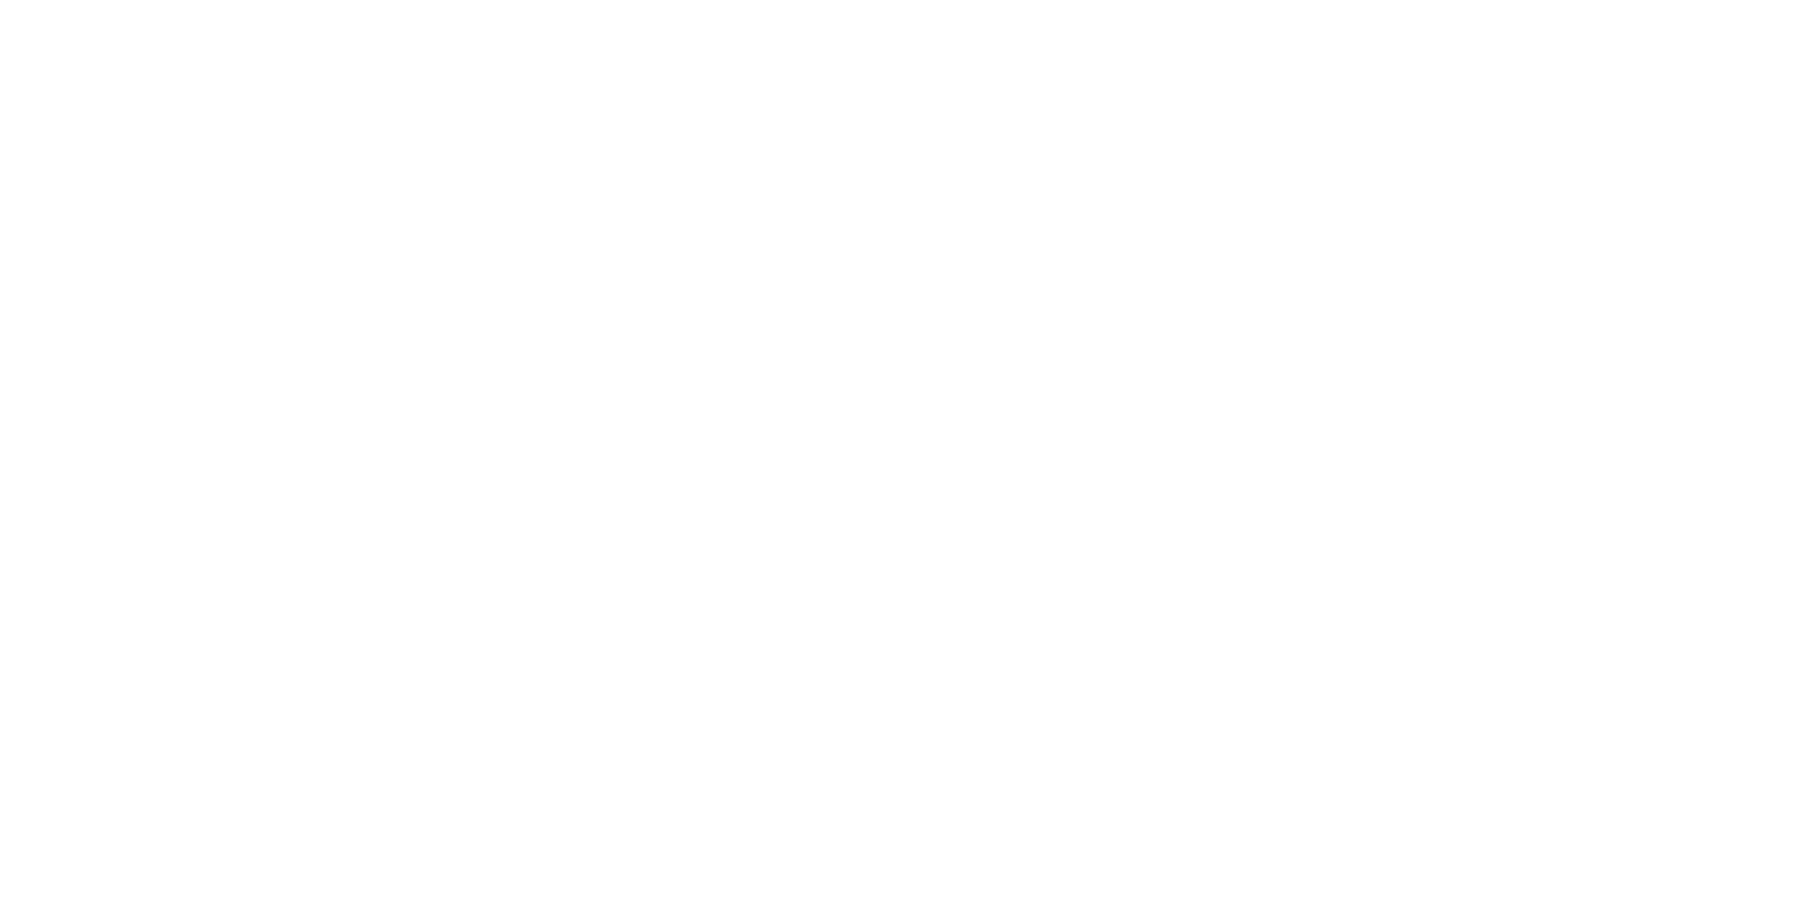

In [81]:
# association profiles for banner figure

fig = plt.figure(figsize=(10, 5))
hex_ordered = [color_dict['hex'].iloc[index-1] for index in order]
ymax = .06

# ordered
peach_ordered = [peach[index-1] for index in order]
celery_ordered = [celery[index-1] for index in order]
driving_ordered = [driving[index-1] for index in order]
comfort_ordered = [comfort[index-1] for index in order]
eggplant_ordered = [eggplant[index-1] for index in order]
grape_ordered = [grape[index-1] for index in order]

# normalized
peach_ordered_normed = np.divide(peach_ordered, sum(peach_ordered))
celery_ordered_normed = np.divide(celery_ordered, sum(celery_ordered))
driving_ordered_normed = np.divide(driving_ordered, sum(driving_ordered))
comfort_ordered_normed = np.divide(comfort_ordered, sum(comfort_ordered))
eggplant_ordered_normed = np.divide(eggplant_ordered, sum(eggplant_ordered))
grape_ordered_normed = np.divide(grape_ordered, sum(grape_ordered))

ax1 = fig.add_subplot(2, 3, 1)
bars1 = ax1.bar(np.linspace(0, 70, 71), peach_ordered_normed, width=.6)
ax1.axes.set_ylim([0, ymax])
ax1.axes.set_xlabel("Peach")

ax2 = fig.add_subplot(2, 3, 4)
bars2 = ax2.bar(np.linspace(0, 70, 71), celery_ordered_normed, width=.6)
ax2.axes.set_ylim([0, ymax])
ax2.axes.set_xlabel("Celery")

ax3 = fig.add_subplot(2, 3, 2)
bars3 = ax3.bar(np.linspace(0, 70, 71), driving_ordered_normed, width=.6)
ax3.axes.set_ylim([0, ymax])
ax3.axes.set_xlabel("Driving")

ax4 = fig.add_subplot(2, 3, 5)
bars4 = ax4.bar(np.linspace(0, 70, 71), comfort_ordered_normed, width=.6)
ax4.axes.set_ylim([0, ymax])
ax4.axes.set_xlabel("Comfort")

ax5 = fig.add_subplot(2, 3, 3)
bars5 = ax5.bar(np.linspace(0, 70, 71), eggplant_ordered_normed, width=.6)
ax5.axes.set_ylim([0, ymax])
ax5.axes.set_xlabel("Eggplant")

ax6 = fig.add_subplot(2, 3, 6)
bars6 = ax6.bar(np.linspace(0, 70, 71), grape_ordered_normed, width=.6)
ax6.axes.set_ylim([0, ymax])
ax6.axes.set_xlabel("Grape")  

for i in range(len(hex_ordered)):
    bars1[i].set_color(hex_ordered[i])   
    bars2[i].set_color(hex_ordered[i])   
    bars3[i].set_color(hex_ordered[i]) 
    bars4[i].set_color(hex_ordered[i])   
    bars5[i].set_color(hex_ordered[i])   
    bars6[i].set_color(hex_ordered[i]) 

plt.rcParams['svg.fonttype'] = 'none' # make text editable in svg

<IPython.core.display.Javascript object>


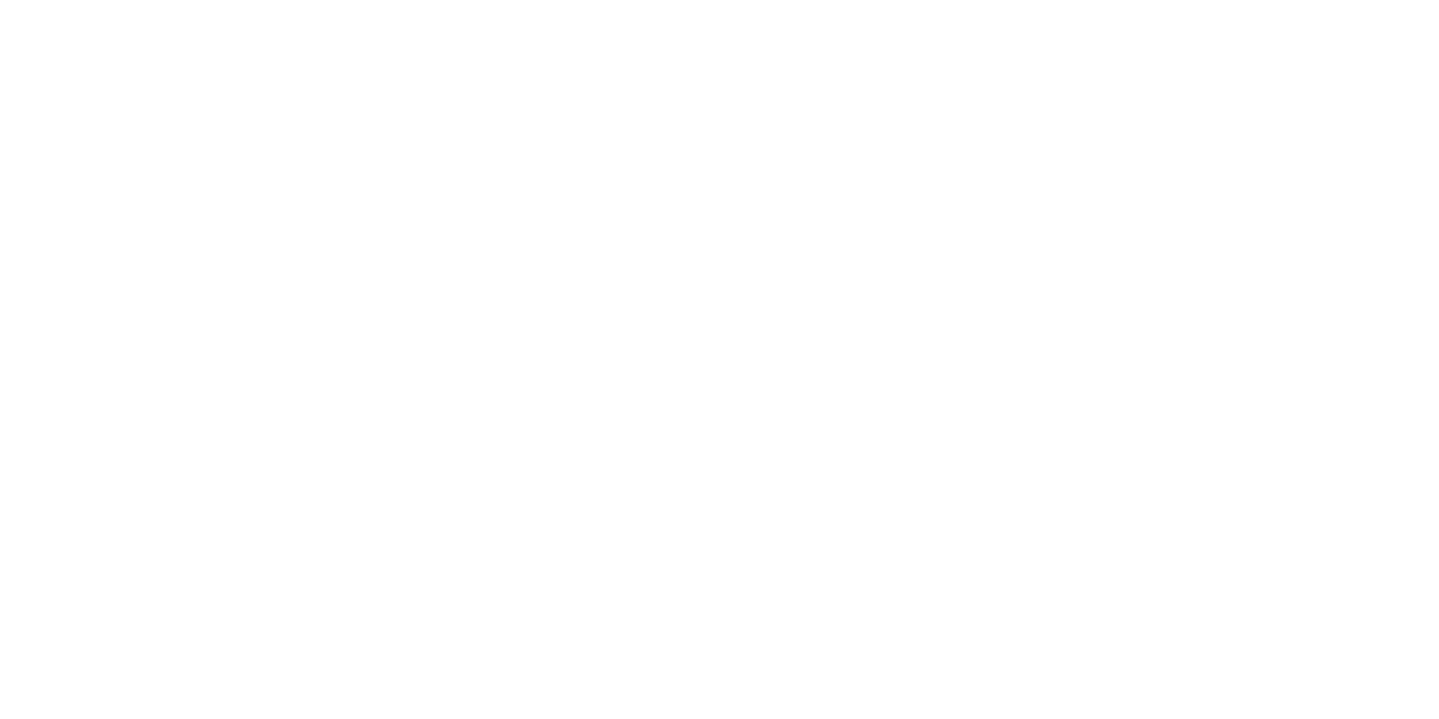

In [82]:
# histograms for banner figure

fig = plt.figure(figsize=[8, 4])
plt.gcf().subplots_adjust(bottom=0.4, wspace=.4)
num_bins = np.arange(0, 1.2, 1/5)

ax1 = fig.add_subplot(1, 3, 1)
ax1.hist(sD_peach_celery, bins=num_bins, orientation='horizontal', color='#a7a9ac')
ax1.axes.set_xlim([0, 1800])
ax1.axes.set_ylim([0, 1])
ax1.axes.set_xlabel('Frequency')
ax1.axes.set_ylabel("Semantic distance")
ax1.set_xticks([])
ax1.set_yticks([0, .5, 1])
ax1.tick_params(direction='in')

ax2 = fig.add_subplot(1, 3, 2)
ax2.hist(sD_driving_comfort, bins=num_bins, orientation='horizontal', color='#a7a9ac')
ax2.axes.set_xlim([0, 1800])
ax2.axes.set_ylim([0, 1])
ax2.axes.set_xlabel('Frequency')
ax2.axes.set_ylabel("Semantic distance")
ax2.set_xticks([])
ax2.set_yticks([0, .5, 1])
ax2.tick_params(direction='in')


ax3 = fig.add_subplot(1, 3, 3)
ax3.hist(sD_eggplant_grape, bins=num_bins, orientation='horizontal', color='#a7a9ac')
ax3.axes.set_xlim([0, 1800])
ax3.axes.set_ylim([0, 1])
ax3.axes.set_xlabel('Frequency')
ax3.axes.set_ylabel("Semantic distance")
ax3.set_yticks([0, .5, 1])
ax3.tick_params(direction='in')

plt.rcParams['svg.fonttype'] = 'none' # make text editable in svg

## Figure 4

In [83]:
def semdist_vector(profile_1, profile_2):
    semdists = get_semdists(profile_1, profile_2)
    semdists = np.reshape(semdists, np.size(semdists))
    semdists = semdists[~np.isnan(semdists)]
    return semdists

def bump(poisson_param, m_ind):
    """
    Create toy profile with max at m_ind.
    """
    assert(poisson_param < m_ind)
    
    diff = m_ind - poisson_param
    back = [((poisson_param+1)**k * np.exp(-3)) / math.factorial(k) for k in range(71)]
    back = (back / sum(back) * 8)

    profile = (np.ones(diff) * back[0]).tolist()
    profile.extend(back[:(71-diff)])
    return profile

In [84]:
# create toy profiles
left_1 = bump(10, 11)
left_2 = bump(14, 41)
right_2 = bump(14, 47)
left_3 = bump(14, 43)
unif_low = np.ones(71) * .25
unif_hi = np.ones(71) * .75
sine = .25 * np.sin(np.arange(0, 1 + 1/70, 1/70) * 6.5) + .35
sine_ish = np.concatenate((sine[:51], np.ones(20)*np.min(sine)), axis=None)
right_bump = bump(14, 59)

In [85]:
def plot_toy_profile(my_ax, num_rows, num_cols, profile1, profile2, i1, i2):
    my_ax.plot(profile1, color='k')
    my_ax.plot(profile2, color='darkgray')
    my_ax.plot([i1, i1, i2, i2], [profile1[i1], profile2[i1], profile1[i2], profile2[i2]], 
             'o', mfc='tab:blue', mec='tab:blue', ms=4, mew=1.5)
    my_ax.axes.set_ylim([0, 1])
    my_ax.tick_params(
        axis='both',       # changes apply to both axes
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,        # ticks along the left edge are off
        labelleft=False,   # labels along the left edge are off
        labelbottom=False) # labels along the bottom edge are off
    
def plot_hist(my_ax, num_rows, num_cols, profile1, profile2):
    my_ax.hist(semdist_vector(profile1, profile2), 
               bins=num_bins, density=True, color="lightgrey", edgecolor='darkgrey')
    my_ax.axes.set_xlim([0, 1])
    my_ax.axes.set_ylim([0, 11])
    my_ax.tick_params(
        axis='both',       # changes apply to both axes
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,        # ticks along the left edge are off
        labelleft=False,   # labels along the left edge are off
        labelbottom=False) # labels along the bottom edge are off

<IPython.core.display.Javascript object>


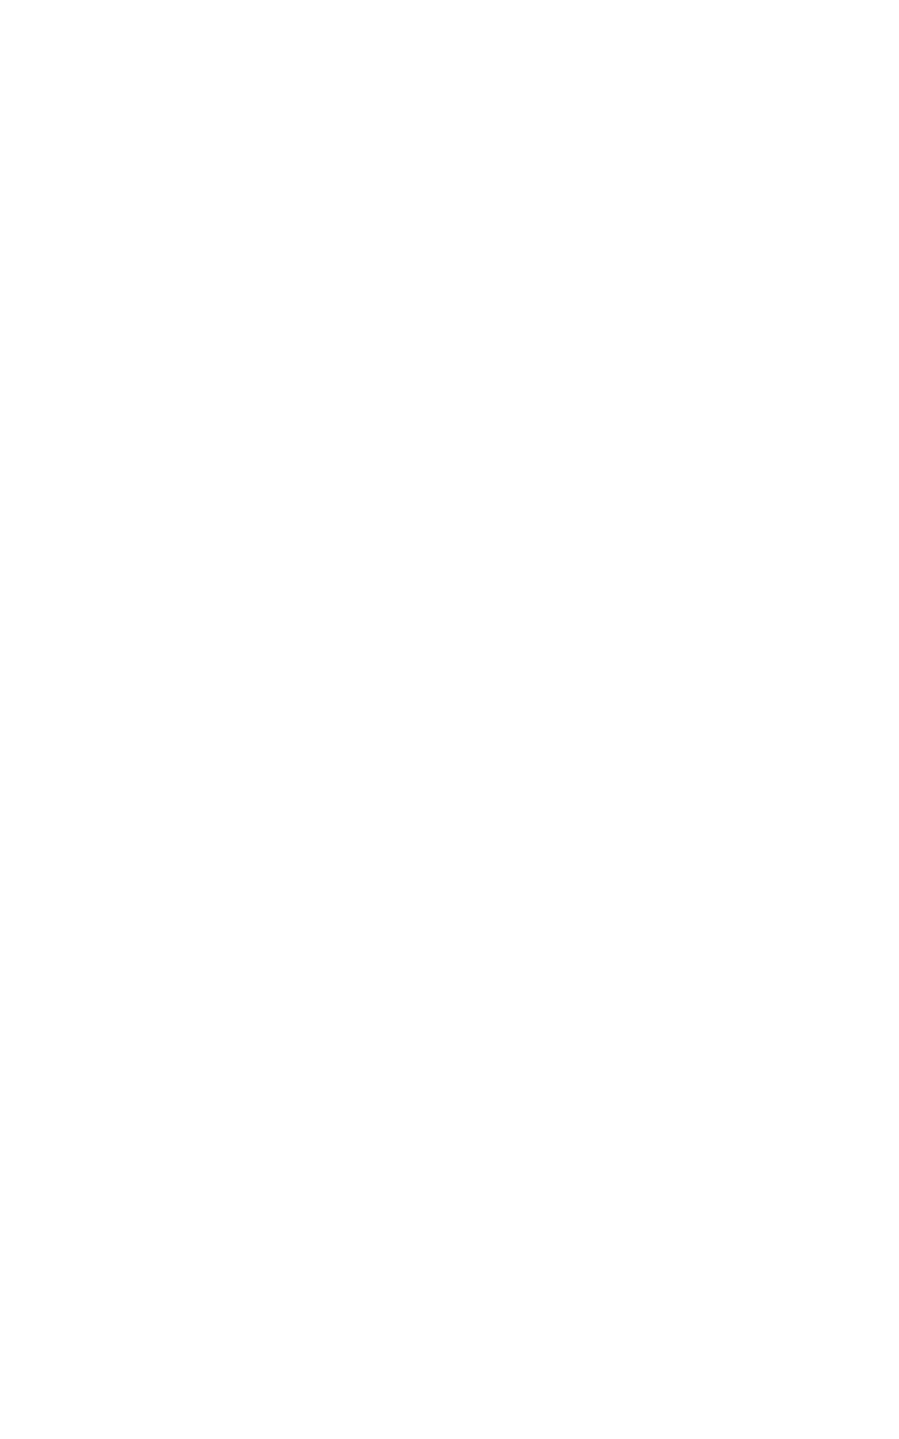

In [86]:
# plot
num_rows, num_cols = 6, 2
fig = plt.figure(figsize=(5, 8))
num_bins = np.arange(0, 1.1, 1/10)

ax1 = fig.add_subplot(num_rows, num_cols, 1)
plot_toy_profile(ax1, num_rows, num_cols, left_2, right_2, 40, 49)

ax2 = fig.add_subplot(num_rows, num_cols, 3)
plot_toy_profile(ax2, num_rows, num_cols, left_2, left_3, 38, 46)

ax3 = fig.add_subplot(num_rows, num_cols, 2)
plot_hist(ax3, num_rows, num_cols, left_2, right_2)

ax4 = fig.add_subplot(num_rows, num_cols, 4)
plot_hist(ax4, num_rows, num_cols, left_2, left_3)

ax5 = fig.add_subplot(num_rows, num_cols, 5)
plot_toy_profile(ax5, num_rows, num_cols, left_2, left_3, 30, 59)

ax6 = fig.add_subplot(num_rows, num_cols, 7)
plot_toy_profile(ax6, num_rows, num_cols, sine_ish, sine_ish+.15, 10, 48)

ax7 = fig.add_subplot(num_rows, num_cols, 6)
plot_hist(ax7, num_rows, num_cols, sine_ish+.25, right_bump)

ax8 = fig.add_subplot(num_rows, num_cols, 8)
plot_hist(ax8, num_rows, num_cols, sine_ish, sine_ish+.25)

ax9 = fig.add_subplot(num_rows, num_cols, 9)
plot_toy_profile(ax9, num_rows, num_cols, unif_low, left_1, 11, 43)


ax10 = fig.add_subplot(num_rows, num_cols, 11)
plot_toy_profile(ax10, num_rows, num_cols, unif_low, unif_hi, 25, 60)

ax11 = fig.add_subplot(num_rows, num_cols, 10)
plot_hist(ax11, num_rows, num_cols, unif_low, left_1)

ax12 = fig.add_subplot(num_rows, num_cols, 12)
plot_hist(ax12, num_rows, num_cols, unif_low, unif_hi)

## Figure 5

In [87]:
# functions
def get_entropy(concept_name, ratings_df):
    """Take concept name as string and ratings dataframe; return entropy"""
    my_profile = ratings_df.loc[concept_name]
    return stats.entropy(my_profile)

def get_GTV(concept_names, ratings_df):
    """Take list of n concept names, output n-concept GTV"""
    my_distributions = []
    for concept_name in concept_names:
        color_profile = ratings_df.loc[concept_name].to_numpy()
        color_distribution = color_profile / sum(color_profile)
        my_distributions.append(color_distribution)
    
    return -1 + sum(np.amax(my_distributions, 0))

def get_max_capacity(concept1, concept2, ratings_df):
    """Take 2 concept name strings, output max capacity (max sD for that concept pair over all color pairs)"""
    semdists = get_semdists(ratings_df.loc[concept1], ratings_df.loc[concept2])
    semdists = semdists.flatten()
    semdists = semdists[~np.isnan(semdists)]
    return max(semdists)

In [88]:
# Get 2-concept vectors
pair_data = pd.DataFrame(data={'c1': [pair[0] for pair in concept_pairs], 'c2': [pair[1] for pair in concept_pairs]})
pair_data['H_c1'] = pair_data.apply(lambda x: get_entropy(x['c1'], ratings), axis=1)
pair_data['H_c2'] = pair_data.apply(lambda x: get_entropy(x['c2'], ratings), axis=1)
pair_data['pair_TV'] = pair_data.apply(lambda x: get_GTV([x['c1'], x['c2']], ratings), axis=1)
pair_data['max_capacity'] = pair_data.apply(
    lambda x: get_max_capacity(x['c1'], x['c2'], ratings), axis=1)
pair_data.head()

,c1,c2,H_c1,H_c2,pair_TV,max_capacity
0,corn,carrot,3.934697,3.906217,0.235549,0.995788
1,corn,eggplant,3.934697,3.999905,0.394613,1.000000
2,corn,celery,3.934697,3.758951,0.307148,0.994995
3,corn,mushroom,3.934697,4.049498,0.329807,0.971718
4,corn,grape,3.934697,4.041732,0.380522,0.999999


In [89]:
# get 4-concept vectors
quartet_data = pd.read_csv("../data/pairwise_SCs.csv", index_col=0)
quartet_data['H_c2'] = quartet_data.apply(lambda x: get_entropy(x['c2'], ratings), axis=1)
quartet_data['H_c1'] = quartet_data.apply(lambda x: get_entropy(x['c1'], ratings), axis=1)
quartet_data['H_c4'] = quartet_data.apply(lambda x: get_entropy(x['c4'], ratings), axis=1)
quartet_data['H_c3'] = quartet_data.apply(lambda x: get_entropy(x['c3'], ratings), axis=1)
quartet_data['quartet_GTV'] = quartet_data.apply(
    lambda x: get_GTV([x['c2'], x['c1'], x['c4'], x['c3']], ratings), axis=1)
quartet_data.head()

,c2,c1,c4,c3,semantic_contrast,H_c2,H_c1,H_c4,H_c3,quartet_GTV
0,corn,carrot,eggplant,celery,0.993,3.934697,3.906217,3.999905,3.758951,0.900129
1,corn,carrot,eggplant,mushroom,0.986,3.934697,3.906217,3.999905,4.049498,0.824709
2,corn,carrot,eggplant,grape,0.776,3.934697,3.906217,3.999905,4.041732,0.652536
3,corn,carrot,eggplant,banana,0.623,3.934697,3.906217,3.999905,3.949950,0.664351
4,corn,carrot,eggplant,peach,0.988,3.934697,3.906217,3.999905,4.022332,0.760039


<IPython.core.display.Javascript object>


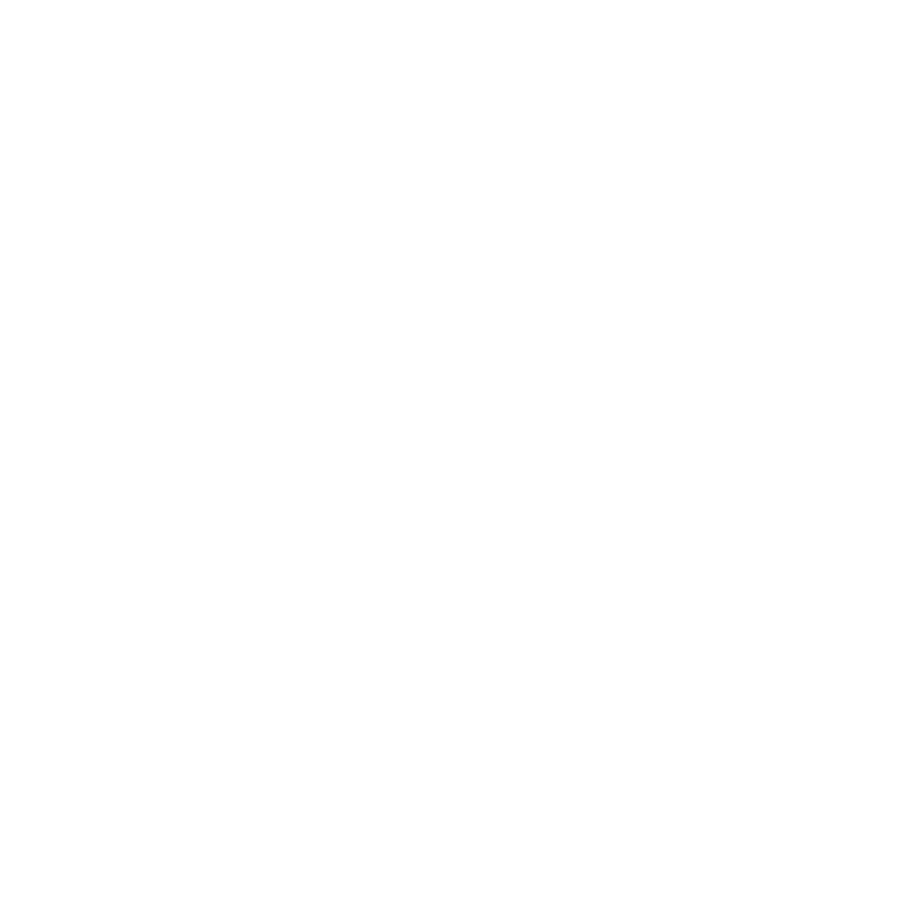

In [90]:
### scatterplot with transforms

fig = plt.figure(figsize=[5, 5])
fig.subplots_adjust(wspace=.3, hspace=.5)

############
# Tuples   #
############

my_ylim_12 = [0, 1]
my_xlim_1, my_xlim_2 = [-4, 0], [-6, -2]

# GET DATA
capacities_pairs = pair_data['max_capacity']
total_var_v = pair_data['pair_TV']
entropy_mean_v = np.mean(np.stack([pair_data['H_c1'].to_numpy(), pair_data['H_c2'].to_numpy()]), 0)

# TRANSFORM 
# divide by max possible value
total_var_v = total_var_v / 1
entropy_mean_v = entropy_mean_v / stats.entropy(np.ones(71) / 71)
# log
total_var_v = np.log(total_var_v)
entropy_mean_v = np.log(1 - entropy_mean_v)

# SUBPLOT 1
ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(total_var_v,  capacities_pairs, 
            s=10, alpha=.5, edgecolors='none', c="#18afb2")
ax1.set_xlabel("log(normalized TV)")
ax1.set_ylabel("2-concept capacity \n for semantic disc.")
# best fit line
m, b = np.polyfit(total_var_v, capacities_pairs, 1)
ax1.plot([my_xlim_1[0]-.1, my_xlim_1[1]+.1], np.multiply(m, [my_xlim_1[0]-.1, my_xlim_1[1]+.1]) + b, 'k')
ax1.plot([min(total_var_v)-.1, max(total_var_v)+.1], np.multiply(m, [min(total_var_v)-.1, max(total_var_v)+.1]) + b, 'k')
# lims
ax1.set_xlim(my_xlim_1)
ax1.set_ylim(my_ylim_12)
# correlation text
ax1.text(-3.9, .9, "r = " + '%.2f' % np.corrcoef(total_var_v, capacities_pairs)[0][1])
ax1.tick_params(direction='in')

# SUBPLOT 2
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(entropy_mean_v, capacities_pairs, 
            s=10, alpha=.5, edgecolors='none', c="#18afb2")
ax2.set_xlabel("log(1 - normalized Mean Entropy)")
# best fit line
m, b = np.polyfit(entropy_mean_v, capacities_pairs, 1)
ax2.plot([my_xlim_2[0]-.1, my_xlim_2[1]+.1], np.multiply(m, [my_xlim_2[0]-.1, my_xlim_2[1]+.1]) + b, 'k')
# lims
ax2.set_xlim(my_xlim_2)
ax2.set_ylim(my_ylim_12)
# correlation text
ax2.text(-5.9, .9, "r = " + '%.2f' % np.corrcoef(entropy_mean_v, capacities_pairs)[0][1])
ax2.tick_params(direction='in')

############
# Quartets #
############

# GET DATA
semcons = quartet_data['semantic_contrast']
entropy_mean_quartet = np.mean(np.stack([
    quartet_data['H_c2'].to_numpy(), 
    quartet_data['H_c1'].to_numpy(), 
    quartet_data['H_c4'].to_numpy(), 
    quartet_data['H_c3'].to_numpy()]), 0)
quartet_TV = quartet_data['quartet_GTV']

# TRANSFORM 
# divide by max possible value
quartet_TV = quartet_TV / 3
entropy_mean_quartet = entropy_mean_quartet / stats.entropy(np.ones(71) / 71)
# log
quartet_TV = np.log(quartet_TV)
entropy_mean_quartet = np.log(1 - entropy_mean_quartet)

# RANDOM SEED (for downsampling)
random.seed(42)
random_indices = random.sample(range(np.size(semcons)), 500)

my_xlim_3, my_xlim_4 = [-3, -1], [-6, -2]
# subplots should share ylim
my_ylim_34 = [0, 1]

# SUBPLOT 3
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(quartet_TV[random_indices],  semcons[random_indices], 
            s=10, alpha=0.5, edgecolors='none', c="#18afb2")
ax3.set_xlabel("log(normalized GTV)")
ax3.set_ylabel("4-concept capacity \n for semantic disc.")
# best fit line
m, b = np.polyfit(quartet_TV,  semcons, 1)
ax3.plot([my_xlim_3[0]-.1, my_xlim_3[1]+.1], np.multiply(m, [my_xlim_3[0]-.1, my_xlim_3[1]+.1]) + b, 'k')
# lims
ax3.set_xlim(my_xlim_3)
ax3.set_ylim(my_ylim_34)
# correlation text
ax3.text(-2.95, .9, "r = " + '%.2f' % np.corrcoef(quartet_TV, semcons)[0][1])
ax3.tick_params(direction='in')

# SUBPLOT 4
ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(entropy_mean_quartet[random_indices],  semcons[random_indices], 
            s=10, alpha=0.5, edgecolors='none', c="#18afb2")
ax4.set_xlabel("log(1 - normalized Mean Entropy)")
# best fit line
m, b = np.polyfit(entropy_mean_quartet,  semcons, 1)
ax4.plot([my_xlim_4[0]-.1, my_xlim_4[1]+.1], np.multiply(m, [my_xlim_4[0]-.1, my_xlim_4[1]+.1]) + b, 'k')
# lims
ax4.set_xlim(my_xlim_4)
ax4.set_ylim(my_ylim_34)
# correlation text
ax4.text(-5.9, .9, "r = " + '%.2f' % np.corrcoef(entropy_mean_quartet, semcons)[0][1]);
ax4.tick_params(direction='in')
plt.rcParams['svg.fonttype'] = 'none' # make text editable in svg

# Table 2

In [91]:
# Use OLS to predict capacity with TV and mean entropy (2-concept model)

predictors = np.transpose(np.array([total_var_v, entropy_mean_v]))
predictors_zscore = stats.zscore(predictors)

X = predictors_zscore
y = capacities_pairs

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:           max_capacity   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     577.9
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           8.90e-81
Time:                        02:14:15   Log-Likelihood:                 249.28
No. Observations:                 190   AIC:                            -492.6
Df Residuals:                     187   BIC:                            -482.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8665      0.005    181.854      0.0

In [92]:
# Use OLS to predict semantic contrast with GTV and mean entropy (4-concept)

predictors = np.transpose(np.array([quartet_TV, entropy_mean_quartet]))
predictors_zscore = stats.zscore(predictors)

X = predictors_zscore
y = semcons

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      semantic_contrast   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     3678.
Date:                Fri, 12 Nov 2021   Prob (F-statistic):               0.00
Time:                        02:14:15   Log-Likelihood:                 3774.0
No. Observations:                4845   AIC:                            -7542.
Df Residuals:                    4842   BIC:                            -7522.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7721      0.002    483.836      0.0

# Figure S.2

In [93]:
%matplotlib inline

my_order = {
    'celery': 0,'banana': 1,'carrot': 2,'peach': 3,
    'corn': 4,'apple': 5,'eggplant': 6,'grape': 7,
    'cherry': 8,'mushroom': 9,'sleeping': 10,'speed': 11,
    'eating': 12,'comfort': 13,'working': 14,'driving': 15,
    'efficiency': 16,'safety': 17,'leisure': 18,'reliability': 19}

# computed from non-normed associations
entropies = [(concept_name, get_entropy(concept_name, ratings)) for concept_name in concept_list]
entropies.sort(key=lambda x: my_order[x[0]])

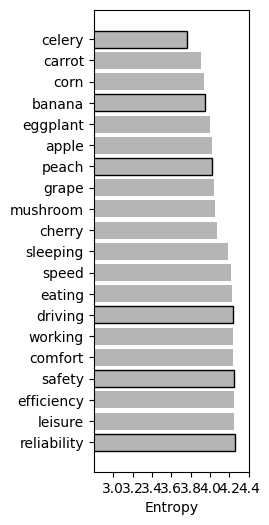

In [94]:
entropies.sort(key=lambda x: x[1])

# plot entropies
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(2, 6))

concept_names = [e[0] for e in entropies]
y_pos = np.flip(np.arange(len(concept_names)))
bars = ax.barh(y_pos, [e[1] for e in entropies], align='center', color='#b5b5b5')
ax.set_yticks(y_pos)
ax.set_yticklabels(concept_names);
ax.set_xlabel("Entropy");
ax.set_xlim(2.8, 4.4);
ax.set_xticks(np.arange(3.0, 4.6, .2))

for i in [0, 3, 6, 13, 16, 19]:
    bars[i].set_edgecolor('k') 
    
plt.rcParams['svg.fonttype'] = 'none' # make text editable in svg

# Figure S.3

In [95]:
%matplotlib notebook
num_concepts = 20
num_colors = 71
num_unique_color_pairs = (num_colors**2 - num_colors) / 2

# 20 x 20 x 71 x 71 array of sDs
sDs = np.empty((20, 20, 71, 71))
sDs[:] = np.nan

# 20 x 20 array of TVs (redundant computations; want to ensure same form as sDs)
TVs = np.empty((20, 20))
TVs[:] = np.nan

# 20 x 20 array of mean entropies
Hs = np.empty((20, 20))
Hs[:] = np.nan

# iterate through all concepts
for i in range(num_concepts):
    concept1_name = concept_list[i]
    concept1_prof = ratings.loc[concept1_name]
    # iterate through all concepts not equal to outer loop concepts
    for j in range(i):
        concept2_name = concept_list[j]
        concept2_prof = ratings.loc[concept2_name]
        
        # compute semantic distances between outer and inner concepts
        sDs[i][j][:][:] = get_semdists(concept1_prof, concept2_prof)
        # compute total variation distance between outer and inner concepts
        TVs[i][j] = get_GTV([concept1_name, concept2_name], ratings)
        # compute mean entropy of outer and inner concept
        Hs[i][j] = np.mean((get_entropy(concept1_name, ratings), get_entropy(concept2_name, ratings)))

In [96]:
# get vectors for TVs and Hs
TVs_v = np.reshape(TVs, (np.size(TVs), 1))
TVs_v = TVs_v[~np.isnan(TVs_v)]

Hs_v = np.reshape(Hs, (np.size(Hs), 1))
Hs_v = Hs_v[~np.isnan(Hs_v)]

In [97]:
granularity = .01
grain_vec = np.arange(0, 1 + granularity, granularity)

# correlation between capacity and tv
corr_capacity_tv = np.empty(len(grain_vec))
# correlation between capacity and entropy
corr_capacity_entropy = np.empty(len(grain_vec))
# standard deviation of area to the right of threshold
std_r = np.empty(len(grain_vec))

# iterate through threshold values
for i in range(len(grain_vec)):
    threshold_i = grain_vec[i]
    # capacity for each concept pair when threshold = t
    capacity_t = np.empty((20, 20))
    capacity_t[:] = np.nan
    # sum of sDs to the right of the threshold for each concept pair when threshold = t
    sD_rightsum = np.empty((20, 20))
    sD_rightsum[:] = np.nan
    
    # iterate through all concept pairs to populate capacity_t and sD_rightsum
    for j in range(num_concepts):
        for k in range(j):
            # semantic distances for concept pair (j, k)
            sDs_jk = sDs[j][k]
            sDs_jk_v = np.reshape(sDs_jk, (np.size(sDs_jk), 1))
            sDs_jk_v = sDs_jk_v[~np.isnan(sDs_jk_v)]
            
            # sDs larger than threshold
            thresh_sDs = [sD for sD in sDs_jk_v if sD > threshold_i]
            # compute capacity
            capacity_t[j][k] = len(thresh_sDs) / len(sDs_jk_v)
            # compute area to right of threshold for given concept pair
            sD_rightsum[j][k] = sum(thresh_sDs)
    
    # capacity vector
    capacity_t_v = np.reshape(capacity_t, (np.size(capacity_t), 1))
    capacity_t_v = capacity_t_v[~np.isnan(capacity_t_v)]
    # sum of SDs to the right ... vector
    sD_rightsum_v = np.reshape(sD_rightsum, (np.size(sD_rightsum), 1))
    sD_rightsum_v = sD_rightsum_v[~np.isnan(sD_rightsum_v)]
    
    # compute correlations
    corr_capacity_tv[i] = np.corrcoef(np.stack([capacity_t_v, TVs_v]))[0][1]
    corr_capacity_entropy[i] = np.corrcoef(np.stack([capacity_t_v, Hs_v]))[0][1]
    std_r[i] = np.std(sD_rightsum_v)

corr_capacity_tv[0], corr_capacity_entropy[0] = np.nan, np.nan

/Users/brianyin/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/brianyin/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<IPython.core.display.Javascript object>


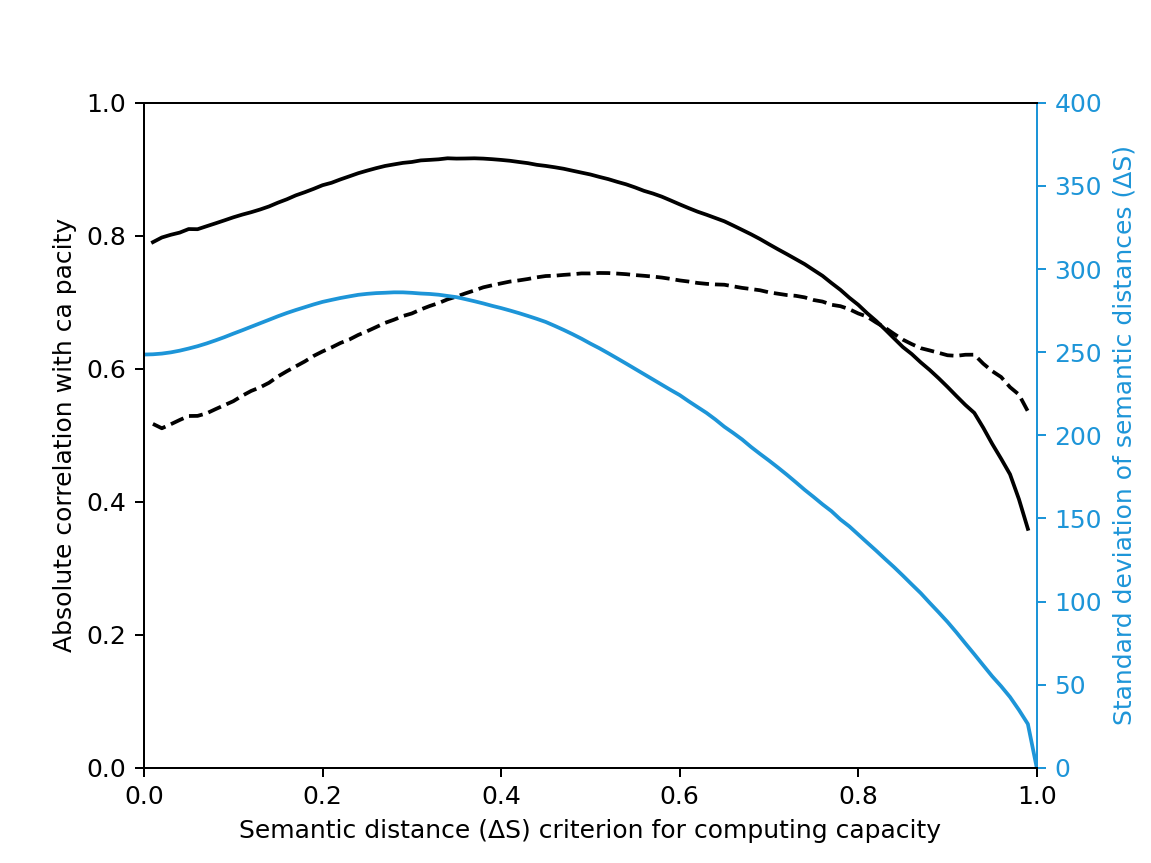

In [98]:
fig = plt.figure()

my_xlim, my_ylim = [0, 100], [0, 1]

ax_color = 'k'
ax2_color = '#1d95d8'

ax = fig.add_subplot(1, 1, 1)
ax.plot(corr_capacity_tv, ax_color, label="TV")
ax.axes.set_xlabel("Semantic distance (ΔS) criterion for computing capacity")
ax.axes.set_ylabel("Absolute correlation with ca pacity")
ax.axes.set_xlim(my_xlim)
ax.axes.set_ylim(my_ylim)
ax.yaxis.label.set_color(ax_color)
ax.tick_params(axis='y', colors=ax_color)


labels = ['%.1f' % dec for dec in np.arange(0, 1.2, .2)]
ax.set_xticklabels(labels);



ax2 = ax.twinx()
ax2.plot(std_r, ax2_color, label="Sigma")
ax2.axes.set_ylabel("Standard deviation of semantic distances (ΔS)")
ax2.yaxis.label.set_color(ax2_color)
ax2.axes.set_ylim([0, 400])
ax2.tick_params(axis='y', colors=ax2_color)
ax2.spines['right'].set_color(ax2_color)
ax2.spines['left'].set_color(ax_color)

best_x2 = np.nanargmax(std_r)
best_std = np.nanmax(std_r)

ax.plot(-1 * corr_capacity_entropy, 'k--', label="Entropy")
# make text editable in svg
plt.rcParams['svg.fonttype'] = 'none'

# Figure S.4

In [99]:
# create triples of (index, hue, saturation) from color_dict
triples = [tuple([color_dict['index'].loc[i+1], 
     color_dict['hsl'].iloc[i].get_value_tuple()[0], 
     color_dict['hsl'].iloc[i].get_value_tuple()[1]]) for i in range(len(color_dict))]
# sort by triples
triples_sorted = sorted(triples, key=lambda x: (x[1] , x[2]))

# get new order of indexes from triple[0]
order = [triple[0] for triple in triples_sorted]
# order of monochromes based on extant figures
monos = [29, 28, 25, 30, 26, 27]
order = monos + order[6:]
# move the reddish color to the last position
reddish = order.pop(6)
order.append(reddish)
# swap those two greens
pos1, pos2  = 26, 27
order[pos1], order[pos2] = order[pos2], order[pos1]

In [100]:
# define TV
def get_TV(concept_names):
    """Take list of concept names, output TV"""
    my_distributions = []
    for concept_name in concept_names:
        color_profile = ratings.loc[concept_name].to_numpy()
        color_distribution = color_profile / sum(color_profile)
        my_distributions.append(color_distribution)
    
    return -1 + sum(np.amax(my_distributions, 0))

get_TV(["celery", "peach"])
difference = np.subtract(ratings.loc["peach"], ratings.loc["celery"])
difference_sorted = [difference[index-1] for index in order]
abs_difference_sorted = np.absolute(difference_sorted)

<IPython.core.display.Javascript object>


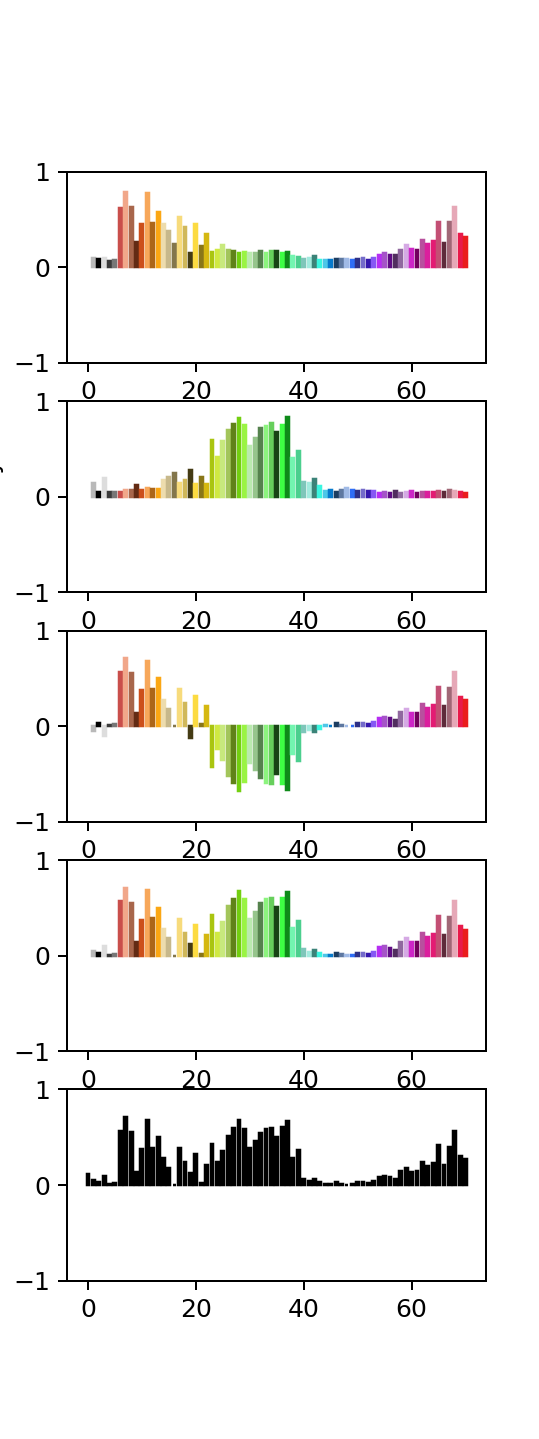

In [101]:
hex_sorted = [color_dict['hex'].iloc[index-1] for index in order]

fig = plt.figure(figsize=(3, 8))

peach, celery = ratings.loc["peach"], ratings.loc["celery"]
peach_sorted, celery_sorted = [peach[index-1] for index in order], [celery[index-1] for index in order]

ax1 = fig.add_subplot(5, 1, 1)
bars1 = ax1.bar(np.linspace(0, 70, 71), peach_sorted, width=.535)
ax1.axes.set_ylim([-1, 1])
ax1.axes.set_ylabel("Peach")

ax2 = fig.add_subplot(5, 1, 2)
bars2 = ax2.bar(np.linspace(0, 70, 71), celery_sorted, width=.535)
ax2.axes.set_ylim([-1, 1])
ax2.axes.set_ylabel("Celery")

ax3 = fig.add_subplot(5, 1, 3)
bars3 = ax3.bar(np.linspace(0, 70, 71), difference_sorted, width=.535)
ax3.axes.set_ylim([-1, 1])
ax3.axes.set_ylabel("Difference")

ax4 = fig.add_subplot(5, 1, 4)
bars4 = ax4.bar(np.linspace(0, 70, 71), abs_difference_sorted, width=.535)
ax4.axes.set_ylim([-1, 1])
ax4.axes.set_ylabel("Absolute Difference")

ax5 = fig.add_subplot(5, 1, 5)
bars5 = ax5.bar(np.linspace(0, 70, 71), abs_difference_sorted, width=.535)
ax5.axes.set_ylim([-1, 1])
ax5.axes.set_ylabel("Sum of Absolute Difference")

for i in range(len(hex_sorted)):
    bars1[i].set_color(hex_sorted[i])   
    bars2[i].set_color(hex_sorted[i])   
    bars3[i].set_color(hex_sorted[i])   
    bars4[i].set_color(hex_sorted[i])  
    bars5[i].set_color('k')  